# Discrete actions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

You can skip training and instead load the last trained policy by changing the flag below.

In [3]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

## MASAC

In [4]:
from navground.learning import DefaultObservationConfig, DefaultStateConfig
from navground.learning.config.discrete_control_action_with_comm import DiscreteControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker, PadReward
from navground.learning.scenarios.pad import render_kwargs

name = "DistributedCommDiscreteWithRewardSharing"
comm_size = 1
kwargs = render_kwargs(comm=True, low=0, high=1, 
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
action = DiscreteControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                             fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
state = DefaultStateConfig(include_y=False, include_position=True, include_velocity=True)
sensors = [comm(size=comm_size), marker()]
train_env = get_env(action=action, observation=observation, state=state,
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0.5), include_success=False)
test_env = get_env(action=action, observation=observation, sensors=sensors, state=state,
                   start_in_opposite_sides=True, 
                   include_success=True, init_success=False, intermediate_success=True, 
                   render_mode='rgb_array', 
                   render_kwargs=render_kwargs(comm=True, low=-1, color_high=(0, 0, 1)))

In [5]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [6]:
%%run_if $training

import os
from benchmarl.algorithms import MasacConfig
from benchmarl.models.mlp import MlpConfig
from benchmarl.experiment import ExperimentConfig
from navground.learning.utils.benchmarl import NavgroundExperiment, ExportPolicyCallback

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac.folder_name

PosixPath('logs/DistributedCommDiscreteWithRewardSharing/MASAC/masac_navground_mlp__60c5e310_25_05_21-16_46_34')

In [7]:
%%run_if $training

experiment_masac.run_for(iterations=50)

mean return = -28.684062957763672: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [19:52<00:00, 23.84s/it]


We can evalute the policy directly using

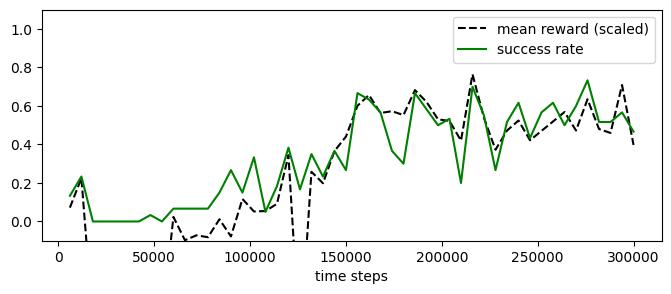

In [8]:
experiment_masac.plot_eval_logs(reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3))

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy
from navground.learning.parallel_env import make_vec_from_penv

test_venv = make_vec_from_penv(test_env)
policy_masac = experiment_masac.load_policy(name='best_policy')
evaluate_policy(policy_masac, test_venv, n_eval_episodes=30)

(-71.88571418921153, 110.51274070806373)

In [10]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=policy_masac, factor=4, select=2, of=31, **kwargs)

In [11]:
from navground.learning.examples.pad import plot_distributed_policy_with_comm

plot_distributed_policy_with_comm(policy_masac, binarize=True)

ImportError: cannot import name 'plot_distributed_policy_with_comm' from 'navground.learning.examples.pad' (/Users/jerome.guzzi/Dev/My/navground_learning/src/navground/learning/examples/pad/__init__.py)

## MAPPO

In [ ]:
train_env_mappo = get_env(action=action, observation=observation, state=state,
                          sensors=sensors, start_in_opposite_sides=True, 
                          reward=PadReward(neighbor_weight=0.5), include_success=False)

In [ ]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MAPPO').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [ ]:
%%run_if $training

from benchmarl.algorithms import MappoConfig

algorithm = MappoConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MAPPO'
config.max_n_iters = 1
os.makedirs(config.save_folder, exist_ok=True)
experiment_mappo = NavgroundExperiment(
    env=train_env_mappo,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_mappo.folder_name

In [ ]:
%%run_if $training

experiment_mappo.run_for(iterations=50)

In [ ]:
experiment_mappo.plot_eval_logs(reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3))

In [ ]:
policy_mappo = experiment_mappo.load_policy(name='best_policy')
evaluate_policy(policy_mappo, test_venv, n_eval_episodes=30)

In [ ]:
display_episode_video(test_env, policy=policy_mappo, factor=4, select=2, of=31, **kwargs)

In [ ]:
plot_distributed_policy_with_comm(policy_mappo, binarize=True)